In [19]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

### Load training and Validation arrays

In [3]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [67]:
npzfile = np.load('shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
y_train=to_categorical(y_train)
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394, 8)


In [69]:
npzfile = np.load('shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
y_valid=to_categorical(y_valid)
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800, 8)


### Check by plotting a Spectogram

Rock


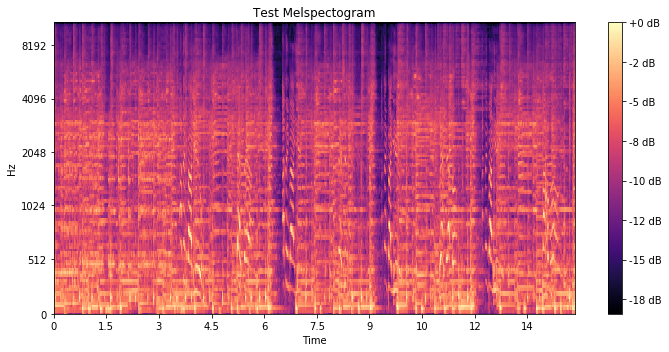

In [70]:
num = 5300
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

### CNN - RNN Model

In [71]:
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [72]:
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 70
NUM_HIDDEN = 64
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    ## LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)
    
    ## Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    ## Softmax Output
    layer = Dense(num_classes)(layer)
   
    layer = Activation('softmax')(layer)
    model_output = layer
    model = Model(model_input, model_output)
  
    
    opt = Adam(lr=0.001)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [73]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/crnn/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history


In [77]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [75]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

Building model...
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 128)         0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 56)          35896     
_________________________________________________________________
batch_normalization_40 (Batc (None, None, 56)          224       
_________________________________________________________________
activation_41 (Activation)   (None, None, 56)          0         
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, None, 56)          0         
_________________________________________________________________
dropout_66 (Dropout)         (None, None, 56)          0         
_________________________________________________________________
convolution_2 (Conv1D)       (None, None

/home/kapish/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/home/kapish/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


6394/6394 [==============================] - 22s 3ms/step - loss: 1.9906 - accuracy: 0.3491 - val_loss: 2.1220 - val_accuracy: 0.2837
Epoch 3/70
6394/6394 [==============================] - 63s 10ms/step - loss: 1.9037 - accuracy: 0.3855 - val_loss: 2.1234 - val_accuracy: 0.3350
Epoch 4/70
6394/6394 [==============================] - 24s 4ms/step - loss: 1.8469 - accuracy: 0.4068 - val_loss: 2.0181 - val_accuracy: 0.3587
Epoch 5/70
6394/6394 [==============================] - 29s 5ms/step - loss: 1.7961 - accuracy: 0.4163 - val_loss: 2.2424 - val_accuracy: 0.3050
Epoch 6/70
6394/6394 [==============================] - 29s 5ms/step - loss: 1.7595 - accuracy: 0.4282 - val_loss: 1.9034 - val_accuracy: 0.3225
Epoch 7/70
6394/6394 [==============================] - 43s 7ms/step - loss: 1.7360 - accuracy: 0.4401 - val_loss: 2.0902 - val_accuracy: 0.2688
Epoch 8/70
6394/6394 [==============================] - 69s 11ms/step - loss: 1.7014 - accuracy: 0.4457 - val_loss: 1.7494 - val_accuracy: 0

6394/6394 [==============================] - 22s 3ms/step - loss: 1.2482 - accuracy: 0.6328 - val_loss: 2.3355 - val_accuracy: 0.3700
Epoch 59/70
6394/6394 [==============================] - 23s 4ms/step - loss: 1.2589 - accuracy: 0.6284 - val_loss: 2.5942 - val_accuracy: 0.2925
Epoch 60/70
6394/6394 [==============================] - 23s 4ms/step - loss: 1.2527 - accuracy: 0.6259 - val_loss: 2.0764 - val_accuracy: 0.3762
Epoch 61/70
6394/6394 [==============================] - 25s 4ms/step - loss: 1.2547 - accuracy: 0.6315 - val_loss: 2.5439 - val_accuracy: 0.3275
Epoch 62/70
6394/6394 [==============================] - 24s 4ms/step - loss: 1.2561 - accuracy: 0.6234 - val_loss: 2.0248 - val_accuracy: 0.4087
Epoch 63/70
6394/6394 [==============================] - 27s 4ms/step - loss: 1.2378 - accuracy: 0.6350 - val_loss: 1.9132 - val_accuracy: 0.4625
Epoch 64/70
6394/6394 [==============================] - 23s 4ms/step - loss: 1.2438 - accuracy: 0.6301 - val_loss: 2.7444 - val_accurac

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


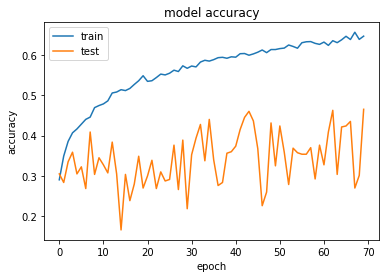

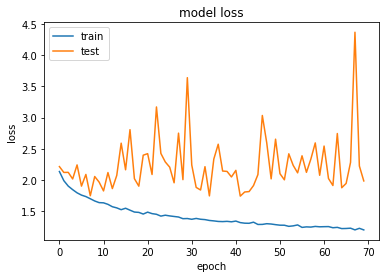

In [78]:
show_summary_stats(history)

In [79]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))


(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.57      0.24      0.34       100
 Experimental       0.37      0.62      0.47       100
         Folk       0.59      0.57      0.58       100
      Hip-Hop       0.72      0.48      0.57       100
 Instrumental       0.55      0.24      0.33       100
International       0.33      0.79      0.47       100
          Pop       0.17      0.01      0.02       100
         Rock       0.54      0.77      0.63       100

     accuracy                           0.47       800
    macro avg       0.48      0.46      0.43       800
 weighted avg       0.48      0.47      0.43       800



In [80]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.465


### Connect to Test Set

In [81]:
from keras.models import load_model

weights_path = 'models/crnn/weights.best.h5'
model = load_model(weights_path)

In [82]:
npzfile = np.load('test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [83]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 7 3.5


In [84]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0000008783668917 0.004623813072130021


In [85]:
X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.64      0.49      0.55       100
 Experimental       0.28      0.22      0.25       100
         Folk       0.19      0.16      0.17       100
      Hip-Hop       0.57      0.85      0.68       100
 Instrumental       0.36      0.34      0.35       100
International       0.46      0.64      0.54       100
          Pop       0.30      0.27      0.28       100
         Rock       0.64      0.56      0.60       100

     accuracy                           0.44       800
    macro avg       0.43      0.44      0.43       800
 weighted avg       0.43      0.44      0.43       800



In [86]:
y_test = keras.utils.to_categorical(y_test, num_classes=8)
model.evaluate(X_test, y_test)

800/800 [==============================] - 1s 2ms/step


[1.7413654899597169, 0.4412499964237213]

In [87]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

[[49  1  6 16  5 13  8  2]
 [ 9 22  8  9 21 17  7  7]
 [ 0 27 16  1 17 14 19  6]
 [ 3  2  1 85  1  6  2  0]
 [ 3 18 29  1 34  8  5  2]
 [ 3  1 10  9  3 64  6  4]
 [ 7  2  9 28  4 12 27 11]
 [ 3  6  4  1  9  4 17 56]]


In [88]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.44125


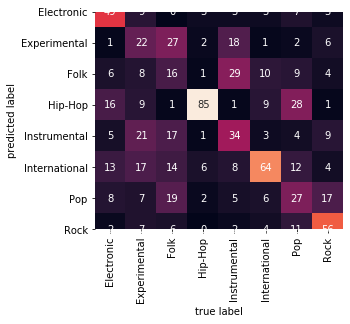

In [89]:
### 8 clusters
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');
